In [ ]:
from optparse import Option
import os
import json
from tqdm import tqdm
from typing import Any, Optional
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel

def load_input(message_path):
    with open(message_path, "r") as f:
        datas = json.load(f)
    return datas

def get_message(datas):
    messages: list[Any] = []
    for d in datas['metadata']['result']:
        message = d['prompt']
        message.append(
            {
                "role": "assistant",
                "content": d['prediction'],
            }
        )
        messages.append(message)
    
    return messages

def get_edit_operations(src_tokens, tgt_tokens):
    m, n = len(src_tokens), len(tgt_tokens)
    
    # dp[i][j] 表示 src[:i] 到 tgt[:j] 的最小编辑距离
    dp = [[0] * (n + 1) for _ in range(m + 1)]
    
    # 初始化边界
    for i in range(m + 1):
        dp[i][0] = i  # 删除所有 src 字符
    for j in range(n + 1):
        dp[0][j] = j  # 插入所有 tgt 字符
    
    # 填充 dp 表
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if src_tokens[i - 1] == tgt_tokens[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]
            else:
                dp[i][j] = min(
                    dp[i - 1][j] + 1,    # 删除
                    dp[i][j - 1] + 1,    # 插入
                    dp[i - 1][j - 1] + 1 # 替换
                )
    
    # 回溯获取操作序列
    operations: list[Any] = []
    i, j = m, n
    while i > 0 or j > 0:
        if i > 0 and j > 0 and src_tokens[i - 1] == tgt_tokens[j - 1]:
            # 相等，无操作，直接回退
            i -= 1
            j -= 1
        elif i > 0 and j > 0 and dp[i][j] == dp[i - 1][j - 1] + 1:
            # 替换
            operations.append((i - 1, j - 1, "mod"))
            i -= 1
            j -= 1
        elif i > 0 and dp[i][j] == dp[i - 1][j] + 1:
            # 删除 src[i-1]
            operations.append((i - 1, j, "del"))  # 注意：j 保持不变，因为目标序列该位置未被消费
            i -= 1
        elif j > 0 and dp[i][j] == dp[i][j - 1] + 1:
            # 插入 tgt[j-1]
            operations.append((i, j - 1, "add"))  # i 不变，因为源序列未消费新 token
            j -= 1
        else:
            break  # 安全退出
    
    # 由于回溯是从后往前，所以反转操作序列
    operations.reverse()
    return operations

def load_input(message_path):
    with open(message_path, "r") as f:
        datas = json.load(f)
    return datas

def get_str_token(input):
    return [
        tokenizer.decode(t) for t in tokenizer.encode(input)
    ]

def load_attentions(attn_dir):
    import re
    def natural_sort_key(s):
        # 将字符串分割为数字和非数字部分，数字转为整数用于比较
        return [int(text) if text.isdigit() else text.lower() for text in re.split(r'([0-9]+)', s)]

    files = [f for f in os.listdir(attn_dir) if f.startswith(f'attention_batch')]
    files = sorted(files, key=natural_sort_key)
    return files

csc_path = "/home/yangchunhao/csc/results/Qwen2.5-VL-7B-Instruct_cscd-ns-test/checkpoints/csc.json"
attn_dir = "/home/yangchunhao/csc/exp/attn"
model_path = "/data/images/llms/Qwen/Qwen2.5-VL-7B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_path)
csc_data = load_input(csc_path)
messages = get_message(csc_data)
sources: list[str] = [d['source'] for d in csc_data['metadata']['result']]
predictions: list[str] = [d['prediction'] for d in csc_data['metadata']['result']]

num_layer, num_head = 28, 28
src_normal_token_st = {
    "max": np.zeros((num_layer, num_head)),
    "avg": np.zeros((num_layer, num_head)),
}
src_edited_token_st = {
    "max": [np.zeros((num_layer, num_head)) for _ in range(3)],
    "avg": [np.zeros((num_layer, num_head)) for _ in range(3)],
}
prdt_normal_token_st = {
    "max": np.zeros((num_layer, num_head)),
    "avg": np.zeros((num_layer, num_head)),
}
prdt_edited_token_st = {
    "max": [np.zeros((num_layer, num_head)) for _ in range(3)],
    "avg": [np.zeros((num_layer, num_head)) for _ in range(3)],
}
ops = {
    "max": np.max,
    "avg": np.average
}
# 读取attn，获取修改位置。
sum_nan = 0
num_src_normal_token = 0
num_src_edited_token = [0, 0, 0]
num_prdt_normal_token = 0
num_prdt_edited_token = 0

for file in tqdm(load_attentions(attn_dir)[:]):
    attn_metadata = np.load(os.path.join(attn_dir, file))
    start_id = attn_metadata['start_id']
    end_id = attn_metadata['end_id']
    print(f"start_id: {start_id}, end_id: {end_id}")
    
    # # 检查attn
    # mask = np.isnan(attn_metadata['attentions'])
    # coords = np.argwhere(mask)
    # if len(coords) > 0:
    #     sum_nan += len(coords)
    #     print(f"start_id: {start_id}")
    #     print(f"end_id {end_id}")
    #     print(coords)
    #     break

    for id in range(start_id, end_id):
        attentions = attn_metadata['attentions'][:, id - start_id]

        source_str_token = get_str_token(sources[id])
        prediction_str_token = get_str_token(predictions[id])
        editions = get_edit_operations(source_str_token, prediction_str_token)
        # 预计算 max / avg
        attn_max = np.max(attentions, axis=-1)    # (layer, head, seq_len)
        attn_avg = np.mean(attentions, axis=-1)   # (layer, head, seq_len)
        attn_stats = {"max": attn_max, "avg": attn_avg}

        source_edit_p = set(e[0] for e in editions)
        prediction_edit_p = set(e[1] for e in editions)

        
        for op, attn_val in attn_stats.items():
            for p in range(len(source_str_token)):
                if p in source_edit_p:
                    if p - 1 >= 0:
                        src_edited_token_st[op][0] += attn_val[:, :, p - 1]
                        num_src_edited_token[0] += 1

                    src_edited_token_st[op][1] += attn_val[:, :, p]
                    num_src_edited_token[1] += 1

                    if p + 1 < attn_val.shape[-1]:
                        src_edited_token_st[op][2] += attn_val[:, :, p + 1]
                        num_src_edited_token[2] += 1
                else:
                    src_normal_token_st[op] += attn_val[:, :, p]
                    num_src_normal_token += 1

        
        shift = len(source_str_token) + 6
        for op, attn_val in attn_stats.items():
            for p in range(len(prediction_str_token)):
                if p in prediction_edit_p:
                    num_prdt_edited_token += 1
                    if shift + p - 1 >= 0:
                        prdt_edited_token_st[op][0] += attn_val[:, :, shift + p - 1]
                    prdt_edited_token_st[op][1] += attn_val[:, :, shift + p]
                    if shift + p + 1 < attn_val.shape[-1]:
                        prdt_edited_token_st[op][2] += attn_val[:, :, shift + p + 1]
                else:
                    num_prdt_normal_token += 1
                    prdt_normal_token_st[op] += attn_val[:, :, shift + p]



In [ ]:
print(num_src_normal_token)
print(num_src_edited_token)
print(num_prdt_normal_token)
print(num_prdt_edited_token)
for op in ops:
    src_normal_token_st[op] /= num_src_normal_token / 2
    src_edited_token_st[op][0] /= num_src_edited_token[0] / 2
    src_edited_token_st[op][1] /= num_src_edited_token[1] / 2
    src_edited_token_st[op][2] /= num_src_edited_token[2] / 2

    prdt_normal_token_st[op] /= num_prdt_normal_token / 2
    prdt_edited_token_st[op][0] /= num_prdt_edited_token / 2
    prdt_edited_token_st[op][1] /= num_prdt_edited_token / 2
    prdt_edited_token_st[op][2] /= num_prdt_edited_token / 2

6314
[112, 112, 112]
6302
140


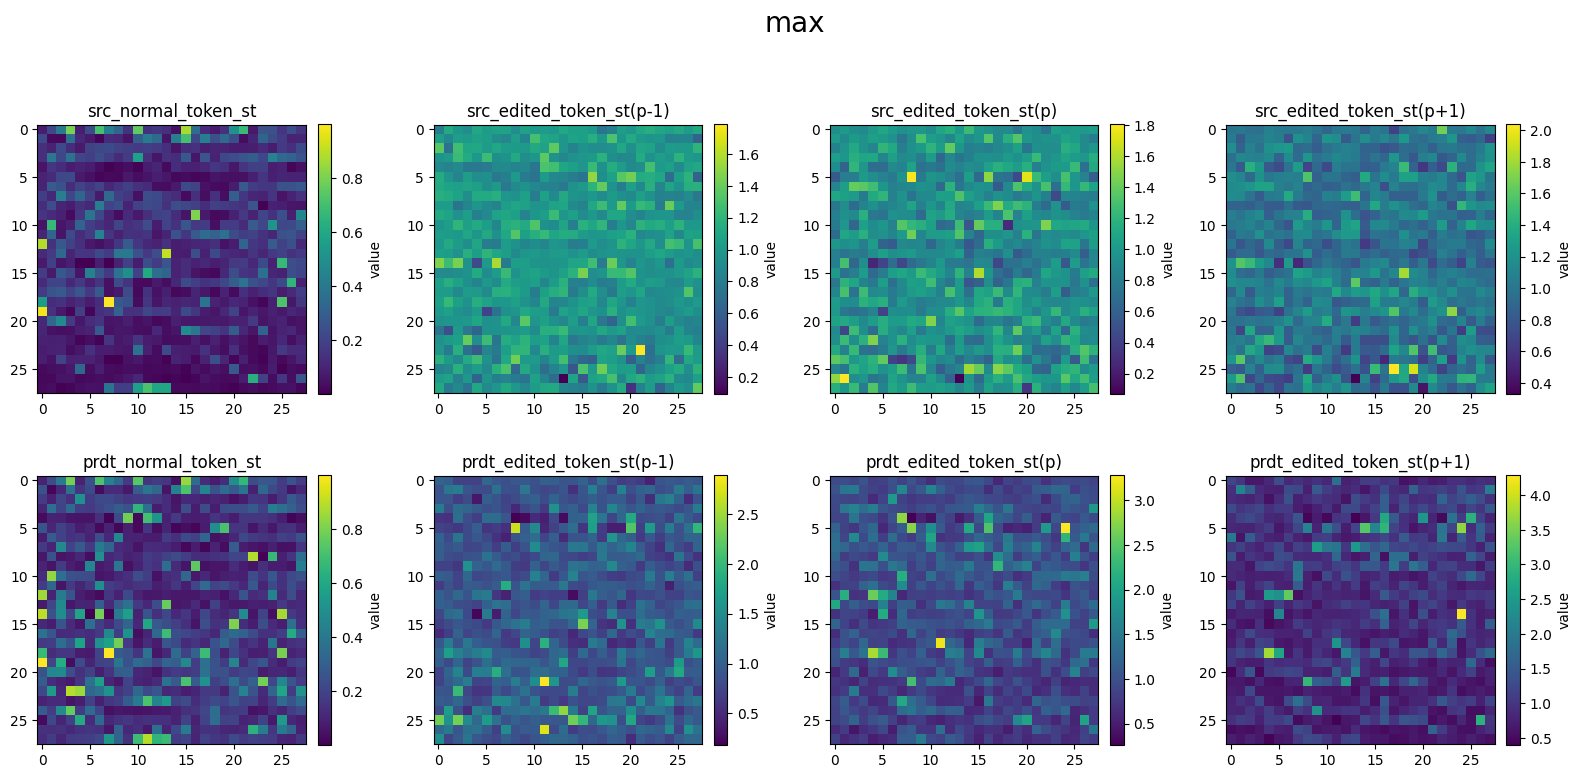

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


# fig, axes = plt.subplots(2, 4, figsize=(16,8))

# op = "max"
# # datas = [
# #     src_normal_token_st[op]),
# #     src_edited_token_st[op][0]),
# #     src_edited_token_st[op][1]),
# #     src_edited_token_st[op][2]),
# #     prdt_normal_token_st[op]),
# #     prdt_edited_token_st[op][0]),
# #     prdt_edited_token_st[op][1]),
# #     prdt_edited_token_st[op][2]),
# # ]


fig, axes = plt.subplots(2, 4, figsize=(16, 8))  # 确保至少有8个子图
axes = axes.flatten()

op = "max"
# datas = [
#     src_normal_token_st[op],
#     src_edited_token_st[op][0] - src_normal_token_st[op],
#     src_edited_token_st[op][1] - src_normal_token_st[op],
#     src_edited_token_st[op][2] - src_normal_token_st[op],
#     prdt_normal_token_st[op],
#     prdt_edited_token_st[op][0] - prdt_normal_token_st[op],
#     prdt_edited_token_st[op][1] - prdt_normal_token_st[op],
#     prdt_edited_token_st[op][2] - prdt_normal_token_st[op],
# ]

datas = [
    src_normal_token_st[op],
    src_edited_token_st[op][0] / src_normal_token_st[op],
    src_edited_token_st[op][1] / src_normal_token_st[op],
    src_edited_token_st[op][2] / src_normal_token_st[op],
    prdt_normal_token_st[op],
    prdt_edited_token_st[op][0] / prdt_normal_token_st[op],
    prdt_edited_token_st[op][1] / prdt_normal_token_st[op],
    prdt_edited_token_st[op][2] / prdt_normal_token_st[op],
]
titles = [
    "src_normal_token_st", "src_edited_token_st(p-1)", "src_edited_token_st(p)", "src_edited_token_st(p+1)",
    "prdt_normal_token_st", "prdt_edited_token_st(p-1)", "prdt_edited_token_st(p)", "prdt_edited_token_st(p+1)"
]

for ax, data, title in zip(axes, datas, titles):
    im = ax.imshow(data)
    ax.set_title(title)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="value")

fig.suptitle(str(op), fontsize=20)  # 确保是字符串
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

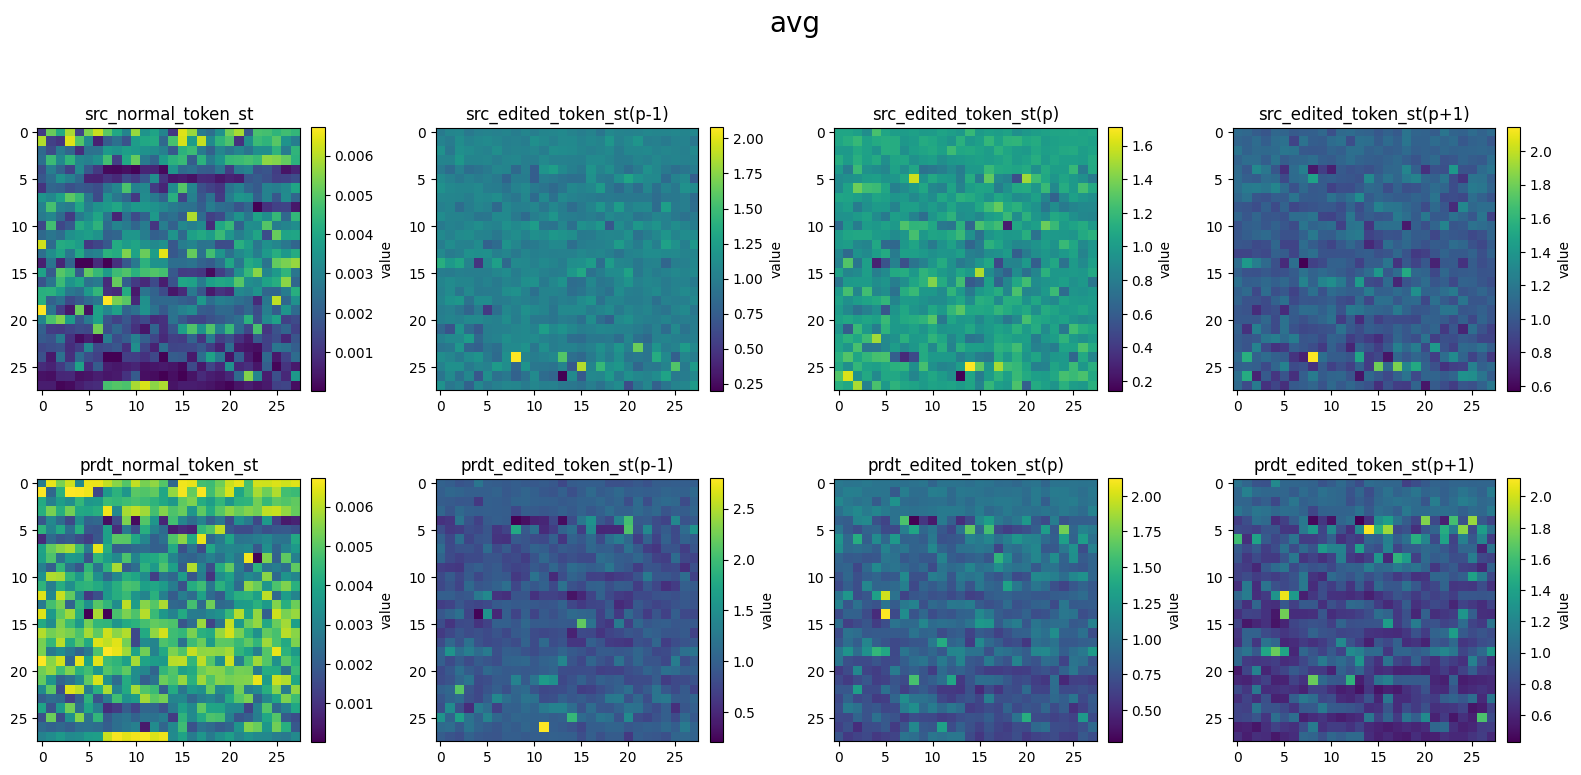

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


# fig, axes = plt.subplots(2, 4, figsize=(16,8))

# op = "max"
# # datas = [
# #     src_normal_token_st[op]),
# #     src_edited_token_st[op][0]),
# #     src_edited_token_st[op][1]),
# #     src_edited_token_st[op][2]),
# #     prdt_normal_token_st[op]),
# #     prdt_edited_token_st[op][0]),
# #     prdt_edited_token_st[op][1]),
# #     prdt_edited_token_st[op][2]),
# # ]


fig, axes = plt.subplots(2, 4, figsize=(16, 8))  # 确保至少有8个子图
axes = axes.flatten()

op = "avg"
# datas = [
#     src_normal_token_st[op],
#     src_edited_token_st[op][0] - src_normal_token_st[op],
#     src_edited_token_st[op][1] - src_normal_token_st[op],
#     src_edited_token_st[op][2] - src_normal_token_st[op],
#     prdt_normal_token_st[op],
#     prdt_edited_token_st[op][0] - prdt_normal_token_st[op],
#     prdt_edited_token_st[op][1] - prdt_normal_token_st[op],
#     prdt_edited_token_st[op][2] - prdt_normal_token_st[op],
# ]

datas = [
    src_normal_token_st[op],
    src_edited_token_st[op][0] / src_normal_token_st[op],
    src_edited_token_st[op][1] / src_normal_token_st[op],
    src_edited_token_st[op][2] / src_normal_token_st[op],
    prdt_normal_token_st[op],
    prdt_edited_token_st[op][0] / prdt_normal_token_st[op],
    prdt_edited_token_st[op][1] / prdt_normal_token_st[op],
    prdt_edited_token_st[op][2] / prdt_normal_token_st[op],
]
titles = [
    "src_normal_token_st", "src_edited_token_st(p-1)", "src_edited_token_st(p)", "src_edited_token_st(p+1)",
    "prdt_normal_token_st", "prdt_edited_token_st(p-1)", "prdt_edited_token_st(p)", "prdt_edited_token_st(p+1)"
]

for ax, data, title in zip(axes, datas, titles):
    im = ax.imshow(data)
    ax.set_title(title)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="value")

fig.suptitle(str(op), fontsize=20)  # 确保是字符串
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [8]:
import numpy as np

datas = [
    np.array([1, 2, 3, 4]),
    np.array([2.0, 1.2, 1, 1])
]
np.savez(
    file="/home/yangchunhao/csc/temp.npz",
    datas = datas
)